# Imports and basics

In [1]:
# Basics
from Solver import Particle, Perceptron, PerceptronModel, VicsekModel, NeuralNetwork, PerceptronMode, Mode, NeuralSwarmModel

import numpy        as np
import os
import logging
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tensorflow as tf

# Logging
# logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import ray
from ray import tune
from ray.rllib.env.multi_agent_env import MultiAgentEnv, make_multi_agent
from ray.rllib.utils import check_env
from ray.rllib.algorithms.maddpg import MADDPGConfig
from ray.tune.registry import register_env
from ray.rllib.policy.policy import PolicySpec

from ray.rllib.algorithms.ppo import PPOConfig
from ray.tune.logger import pretty_print

# For custom models
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.models import ModelCatalog

import gymnasium as gym
from gymnasium.spaces import Box
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

2023-08-23 10:18:13.484333: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-23 10:18:13.508316: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 10:18:13.859442: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/renlephy/miniconda3/envs/bachelor/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/renlephy/mini

# Simulation settings

In [2]:
# Simulation settings
settings = {
        #                  N,      L,      v,      noise,  r
        "testing": [       10,     10,     0.03,   0.1,    1],
        "small": [         100,    10,     0.03,   0.1,    1],
        "medium": [        1000,   10,     0.03,   0.1,    1],
    }
    
# Choose between RADIUS, FIXED, FIXEDRADIUS (don't use RADIUS)
mode = Mode.FIXEDRADIUS
# Flags
ZDimension = False     # 2D or 3D
seed = False           # Random seed
# Choose settings
chosen_settings = settings["testing"]
N       = chosen_settings[0]
L       = chosen_settings[1]
v       = chosen_settings[2]
noise   = chosen_settings[3]
r       = chosen_settings[4]

k_neighbors = 5
# Timesteps in an episode
T = 100

# Custom multi agent environment

In [3]:
class MultiAgentSimulationEnv(MultiAgentEnv):
    minimum = 0.0
    maximum = 2 * np.pi
    
    def __init__(self, config):
        super().__init__()
        self.num_agents = N
        self._spaces_in_preferred_format = True
        self._agent_ids = list(range(self.num_agents))
        
        # We asume the same action space for all agents
        self.action_space = Box(low=self.minimum, high=self.maximum, shape=(), dtype=np.float32)
        
        # We assume the same observation space for all agents
        self.observation_space = Box(low=self.minimum, high=self.maximum, shape=(k_neighbors + 1,), dtype=np.float32)
        
        self.simulation = NeuralSwarmModel(N, L, v, noise, r, mode, k_neighbors, ZDimension, seed=seed)
        self.new_angles = np.zeros(shape=(N,), dtype=np.float32)
        self.index = 0

    def reset(self, seed=None, options=None):
        # Reset the state of the environment to an initial state
        observations = {}
        infos = {}
        self.simulation = NeuralSwarmModel(N, L, v, noise, r, mode, k_neighbors, ZDimension, seed=False)
        self.index = 0
        self.new_angles = np.zeros(shape=(N,), dtype=np.float32)
        for agent_id in range(self.num_agents):
            observations[agent_id] = self.simulation.get_angles(agent_id)
        return observations, infos

    def step(self, action_dict):
        # Actions for all agents are provided in a dictionary
        
        # Rewards for all agents are provided in a dictionary {agent_id: reward}
        rewards = {}
        # Observations for all agents are provided in a dictionary {agent_id: observation}
        new_obs = {}
        # Dones for all agents are provided in a dictionary {agent_id: done (boolean))}
        dones = {}
        # Truncated for all agents are provided in a dictionary {agent_id: truncated (boolean))}
        # Truncated is used to indicate that the episode was ended early
        truncated = {}
        # Infos for all agents are provided in a dictionary {agent_id: info}
        # Infos can be used to provide extra information about an agent's state or action
        infos = {}
        
        # Collect all actions and set dones
        for agent_id, action in action_dict.items():
            action = np.clip(action, self.minimum, self.maximum)
            self.new_angles[agent_id] = action
            dones[agent_id] = True if self.index >= T else False
            
        # Update the simulation
        self.simulation.update_angles(self.new_angles)
        self.simulation.update()
        self.index += 1
        reward = self.simulation.mean_direction2D()
        
        # Collect observations and rewards
        for agent_id in range(self.num_agents):
            new_obs[agent_id] = self.simulation.get_angles(agent_id)
            rewards[agent_id] = reward
            
        # Ends the episode if all agents are done
        dones['__all__'] = all(dones.values())
        # Truncated is used to indicate that the episode was ended early (opposite of dones)
        truncated['__all__'] = not dones['__all__']
        
        return new_obs, rewards, dones, truncated, infos

    def render(self, mode='rgb_array'):
        fig, ax = plt.subplots()
        ax.set_xlim(0, L)
        ax.set_ylim(0, L)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("Simulation")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_facecolor('black')
        for agent_id in range(self.num_agents):
            x, y, angle = self.simulation.particles[agent_id].x, self.simulation.particles[agent_id].y, self.simulation.particles[agent_id].angle
            ax.plot(x, y, 'o', color='white', markersize=5)
            ax.arrow(x, y, 0.5 * np.cos(angle), 0.5 * np.sin(angle), color='white', width=0.1)

        if mode == 'human':
            plt.show()
        elif mode == 'rgb_array':
            fig.canvas.draw()
            image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            plt.close(fig)
            return image_from_plot


    def close(self):
        # Optional: Clean up. Called at the end of an episode.
        pass
    
    # Optional methods
    def observation_space_contains(self, observation):
        # Check if the observation is a valid observation
        # Obervation is a dictionary {agent_id: observation}
        observations = observation.values()
        return all([self.observation_space.contains(obs) for obs in observations])
    
    def action_space_contains(self, action):
        # Check if the action is a valid action
        # Action is a dictionary {agent_id: action}
        actions = action.values()
        return all([self.action_space.contains(act) for act in actions])
    
    def observation_space_sample(self):
        return {agent_id: self.observation_space.sample() for agent_id in range(self.num_agents)}

    def action_space_sample(self, action):
        return {agent_id: self.action_space.sample() for agent_id in range(self.num_agents)}


# Basic tests on the environment

Starting episode 1
Step 100 finished
Episode 1 finished after 100 timesteps with rewards: 0.14410832714022614
Rendering video...  Done


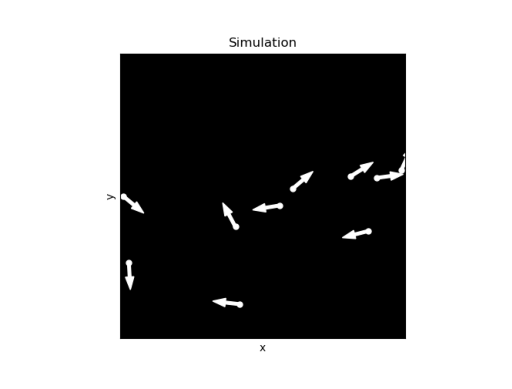

In [6]:
env = MultiAgentSimulationEnv(None)

for i_episode in range(1):
    observations, infos = env.reset()
    total_rewards = {agent_id: 0 for agent_id in observations.keys()}
    print(f"Starting episode {i_episode + 1}")
    
    frames = []  # List to store frames of the episode
    # Max steps per episode
    for t in range(T + 1):
        # Render the environment
        frames.append(env.render(mode='rgb_array'))
        
        # Choose random actions
        actions = {agent_id: env.action_space.sample() for agent_id in observations.keys()}
        
        observations, rewards, dones, truncated, infos = env.step(actions)
        
        for agent_id, reward in rewards.items():
            total_rewards[agent_id] += reward
            
        print(f"Step {t}... \r", end="")
            
        if any(dones.values()):
            print(f"Step {t} finished")
            # The reward is the same for all agents. We just take the first one.
            print(f"Episode {i_episode + 1} finished after {t} timesteps with rewards: {next(iter(rewards.values()))}")
            break

print("Rendering video...  ", end="")
    
fig = plt.figure()

def update(num, frames):
    plt.clf()
    # Remove ticks, labels and axes
    plt.axis('off')
    plt.imshow(frames[num])

ani = animation.FuncAnimation(fig, update, frames=range(len(frames)), fargs=[frames])
# Create directory if it doesn't exist
path = "test_videos"
if not os.path.exists(path):
    os.makedirs(path)
ani.save(f"{path}/random_policy_env_test.avi", writer='ffmpeg', fps=50)

print("Done")

env.close()

# Set up policy management

In [ ]:
# Alternative policy mapping function to map ALL agents to the shared policy
def policy_mapping_fn_shared(agent_id, episode, **kwargs):
    return "shared_policy"

# Function to get the shared policy
def get_shared_policy():
    policies = {
        "shared_policy": PolicySpec(
            policy_class=None,
            observation_space=env.observation_space, 
            action_space=env.action_space, 
            config={
                "model": {
                    "custom_model": "SharedArchitectureModel",
                    # Additional custom model config parameters if needed
                    # For example:
                    # "custom_model_config": {"shared_layers": [64, 64]}
                    # or
                    # "custom_model_config": {"critic_layers": [64, 64]} 
                }
            }
        )
    }
    return policies

# Define neural network architecture

In [ ]:
# Define a custom actor network with tensorflow
class CustomActorCriticModel(TFModelV2):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name, critic_layers=(64, 64)):
        super(CustomActorCriticModel, self).__init__(obs_space, action_space, num_outputs, model_config, name)
        
        # Actor network
        self.actor = tf.keras.Sequential([
            tf.keras.layers.Dense(1, activation="linear")
        ])

        # Critic network
        critic_input = tf.keras.Input(shape=obs_space.shape)
        critic_model = critic_input
        for units in critic_layers:
            critic_model = tf.keras.layers.Dense(units, activation='relu')(critic_model)
        self.critic_value = tf.keras.layers.Dense(1, activation=None)(critic_model)
        self.critic = tf.keras.Model(inputs=critic_input, outputs=self.critic_value)

        # Build the networks to set the weights
        self.actor.build(input_shape=obs_space.shape)
        self.critic.build(input_shape=obs_space.shape)

    def forward(self, input_dict, state, seq_lens):
        actor_output = self.actor(input_dict["obs_flat"])
        self._last_critic_value = self.critic(input_dict["obs_flat"])
        return actor_output, state

    def value_function(self):
        return tf.squeeze(self._last_critic_value, axis=-1)
    
class SharedArchitectureModel(TFModelV2):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name, shared_layers=None):
        super(SharedArchitectureModel, self).__init__(obs_space, action_space, num_outputs, model_config, name)
        
        # Shared layers
        if shared_layers:
            self.shared = tf.keras.Sequential([
                tf.keras.layers.Dense(units, activation=None) for units in shared_layers
            ])
        else:
            self.shared = None

        # Actor head
        self.actor_head = tf.keras.layers.Dense(num_outputs, activation=None)
        
        # Critic head
        self.critic_head = tf.keras.layers.Dense(1, activation=None)

        # Build the networks to set the weights
        dummy_obs = tf.keras.Input(shape=obs_space.shape)
        if self.shared:
            shared_features = self.shared(dummy_obs)
        else:
            shared_features = dummy_obs
        self.actor_head(shared_features)
        self.critic_head(shared_features)

    def forward(self, input_dict, state, seq_lens):
        if self.shared:
            shared_features = self.shared(input_dict["obs_flat"])
        else:
            shared_features = input_dict["obs_flat"]
        actor_output = self.actor_head(shared_features)
        self._last_critic_value = self.critic_head(shared_features)
        return actor_output, state

    def value_function(self):
        return tf.squeeze(self._last_critic_value, axis=-1)


ModelCatalog.register_custom_model("SharedArchitectureModel", SharedArchitectureModel)

# Set up the algorithm and all the parameters

In [ ]:
# config = MADDPGConfig()
config = PPOConfig()

config.update_from_dict({
    # This will evaluate the model every x training iterations
    "evaluation_interval": 2,
    "evaluation_config": {
        "render_env": True,
        "record_env": "./evaluation_videos/",
    },
    "render_env": True,
    "record_env": "./evaluation_videos/",

    # Force the local worker to have an environment for evaluation
    "create_env_on_driver": True,
    
})


def simple_env_creator(config):
    env = MultiAgentSimulationEnv(config)
    
    return env

# Register the custom environment
register_env("multi_agent_simulation", simple_env_creator)
config.environment("multi_agent_simulation")

# Disable automatic environment checking
config.environment(disable_env_checking=True)

# Test if the environment is valid
check_env(simple_env_creator(config), config)

policies = get_shared_policy()
# policies = get_individual_policies()      # Uncomment this line to use individual policies
# policies = {"policy_%d" % i: gen_policy(i) for i in range(N)}


config.update_from_dict({
    "simple_optimizer": True,
    # "policies": policies,
    # "policy_mapping_fn": policy_mapping_fn,
    # "policy_mapping_fn": policy_mapping_fn_individual,
    # "policies_to_train": list(policies.keys()),
    # "count_steps_by": "env_steps",
    "framework": "tf",
    "use_local_critic": False,
    "use_state_preprocessor": True,
    # "eager_tracing": False,
    # "observation_space": env.observation_space,
    # "action_space": env.action_space,
    "multiagent": {
        "policies": policies,
        "policy_mapping_fn": policy_mapping_fn_shared,
    },
    "reuse_actors": True,
    "num_gpus": 1,
    # "num_cpus_per_worker": 2,
    
    # Custom model
    "model": {
        "custom_model": "SharedArchitectureModel"
    },
    "train_batch_size": 1000,
})

```python
extra_python_environs_for_driver {}
extra_python_environs_for_worker {}
num_gpus 1
num_cpus_per_worker 1
num_gpus_per_worker 0
_fake_gpus False
num_learner_workers 0
num_gpus_per_learner_worker 0
num_cpus_per_learner_worker 1
local_gpu_idx 0
custom_resources_per_worker {}
placement_strategy PACK
eager_tracing True
eager_max_retraces 20
tf_session_args {'intra_op_parallelism_threads': 2, 'inter_op_parallelism_threads': 2, 'gpu_options': {'allow_growth': True}, 'log_device_placement': False, 'device_count': {'CPU': 1}, 'allow_soft_placement': True}
local_tf_session_args {'intra_op_parallelism_threads': 8, 'inter_op_parallelism_threads': 8}
torch_compile_learner False
torch_compile_learner_what_to_compile TorchCompileWhatToCompile.FORWARD_TRAIN
torch_compile_learner_dynamo_backend inductor
torch_compile_learner_dynamo_mode None
torch_compile_worker False
torch_compile_worker_dynamo_backend onnxrt
torch_compile_worker_dynamo_mode None
env multi_agent_simulation
env_config {}
observation_space None
action_space None
env_task_fn None
render_env False
clip_rewards None
normalize_actions True
clip_actions False
disable_env_checking True
_is_atari None
auto_wrap_old_gym_envs True
action_mask_key action_mask
env_runner_cls None
num_envs_per_worker 1
sample_collector <class 'ray.rllib.evaluation.collectors.simple_list_collector.SimpleListCollector'>
sample_async False
enable_connectors True
update_worker_filter_stats True
use_worker_filter_stats True
rollout_fragment_length auto
batch_mode truncate_episodes
remote_worker_envs False
remote_env_batch_wait_ms 0
validate_workers_after_construction True
preprocessor_pref deepmind
observation_filter NoFilter
compress_observations False
enable_tf1_exec_eagerly False
sampler_perf_stats_ema_coef None
gamma 0.99
lr 5e-05
grad_clip None
grad_clip_by global_norm
train_batch_size 4000
model {'_disable_preprocessor_api': False, '_disable_action_flattening': False, 'fcnet_hiddens': [256, 256], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_use_n_prev_actions': 0, 'attention_use_n_prev_rewards': 0, 'framestack': True, 'dim': 84, 'grayscale': False, 'zero_mean': True, 'custom_model': None, 'custom_model_config': {}, 'custom_action_dist': None, 'custom_preprocessor': None, 'encoder_latent_dim': None, 'always_check_shapes': False, 'lstm_use_prev_action_reward': -1, '_use_default_native_models': -1}
optimizer {}
max_requests_in_flight_per_sampler_worker 2
_learner_class None
_enable_learner_api True
explore True
exploration_config {}
algorithm_config_overrides_per_module {}
policy_map_capacity 100
policy_mapping_fn <function policy_mapping_fn_shared at 0x7f40210bb760>
policies_to_train None
policy_states_are_swappable False
observation_fn None
count_steps_by env_steps
input_config {}
actions_in_input_normalized False
postprocess_inputs False
shuffle_buffer_size 0
output None
output_config {}
output_compress_columns ['obs', 'new_obs']
output_max_file_size 67108864
offline_sampling False
evaluation_interval 2
evaluation_duration 10
evaluation_duration_unit episodes
evaluation_sample_timeout_s 180.0
evaluation_parallel_to_training False
evaluation_config None
off_policy_estimation_methods {}
ope_split_batch_by_episode True
evaluation_num_workers 0
always_attach_evaluation_results False
enable_async_evaluation False
in_evaluation False
sync_filters_on_rollout_workers_timeout_s 60.0
keep_per_episode_custom_metrics False
metrics_episode_collection_timeout_s 60.0
metrics_num_episodes_for_smoothing 100
min_time_s_per_iteration None
min_train_timesteps_per_iteration 0
min_sample_timesteps_per_iteration 0
export_native_model_files False
checkpoint_trainable_policies_only False
logger_creator None
logger_config None
log_level WARN
log_sys_usage True
fake_sampler False
seed None
ignore_worker_failures False
recreate_failed_workers False
max_num_worker_restarts 1000
delay_between_worker_restarts_s 60.0
restart_failed_sub_environments False
num_consecutive_worker_failures_tolerance 100
worker_health_probe_timeout_s 60
worker_restore_timeout_s 1800
rl_module_spec None
_enable_rl_module_api True
_AlgorithmConfig__prior_exploration_config {'type': 'StochasticSampling'}
_tf_policy_handles_more_than_one_loss False
_disable_preprocessor_api False
_disable_action_flattening False
_disable_execution_plan_api True
_disable_initialize_loss_from_dummy_batch False
simple_optimizer True
policy_map_cache -1
worker_cls -1
synchronize_filters -1
replay_sequence_length None
lr_schedule None
use_critic True
use_gae True
use_kl_loss True
kl_coeff 0.2
kl_target 0.01
sgd_minibatch_size 128
num_sgd_iter 30
shuffle_sequences True
vf_loss_coeff 1.0
entropy_coeff 0.0
entropy_coeff_schedule None
clip_param 0.3
vf_clip_param 10.0
vf_share_layers -1
use_local_critic False
use_state_preprocessor True
reuse_actors True
lambda 1.0
input sampler
policies {'shared_policy': (None, Box(0.0, 6.2831855, (6,), float32), Box(0.0, 6.2831855, (), float32), {})}
callbacks <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>
create_env_on_driver True
custom_eval_function None
framework tf
num_cpus_for_driver 1
num_workers 2
```

In [ ]:
# Print the configuration (contains all the hyperparameters)
for key, value in config.items():
    # print(key, value)
    pass

In [ ]:
algo = config.build() 

In [ ]:
training_iterations = 6
video_dir = "./evaluation_videos"
ckeckpoint_dir = "./checkpoints"

if not os.path.exists(video_dir):
    os.makedirs(video_dir)

for i in range(training_iterations):
    
    iteration = algo.iteration

    if i % 5 == 0:
        checkpoint_dir = algo.save()
        print(f"Checkpoint saved in directory {checkpoint_dir}")
        
    # Get the number of iterations from the algo object

    # Save frames as a video
    if iteration % 1 == 0:
        # Manual rendering after each training iteration
        print(f"Rendering episode {iteration}... ", end="")
        tempEnv = MultiAgentSimulationEnv(config)
        dones = {"__all__": False}
        observations, infos = tempEnv.reset()
        worker = algo.workers.local_worker()
        policy = worker.get_policy("shared_policy")

        frames = []  # List to store frames of the episode
            
        while not dones["__all__"]:
            # convert the observation dictionary to a list of observation arrays
            observation_list = [np.reshape(observation, (1, -1)) for observation in observations.values()]

            # concatenate along the first dimension to make a batch
            observation_batch = np.concatenate(observation_list, axis=0)
            
            # Assuming your policy is called "shared_policy"
            actions, _, _ = policy.compute_actions(observation_batch)
            
            # map back the batch actions to individual agent IDs
            action_dict = {agent_id: action for agent_id, action in zip(observations.keys(), actions)}

            observations, rewards, dones, truncated, infos = tempEnv.step(action_dict)
            frame = tempEnv.render(mode='rgb_array')
            frames.append(frame)
        
        # Get id of the run from the ckeckpoint dir
        checkpoint_id = checkpoint_dir.split("/")[-2].split("-")[-1]
        
        # Create folder for the video
        if not os.path.exists(os.path.join(video_dir, checkpoint_id)):
            os.makedirs(os.path.join(video_dir, checkpoint_id))
        video_filename = os.path.join(video_dir, f"{checkpoint_id}/episode_{iteration}.avi")
        
        fig = plt.figure()

        def update(num, frames):
            plt.clf()
            # Remove ticks, labels and axes
            plt.axis('off')
            plt.imshow(frames[num])

        ani = animation.FuncAnimation(fig, update, frames=range(len(frames)), fargs=[frames])

        ani.save(video_filename, writer='ffmpeg', fps=50)
        
        print("Done.")
    
    # Print progress (based on iterations + training_iterations)
    print(f"Training iteration: {iteration}/{iteration + training_iterations}")
    
    result = algo.train()

In [ ]:
# Print the weights of the policy
print(algo.get_weights("shared_policy"))
